In [1]:
import os
import pandas as pd
import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image
from tqdm import tqdm

In [2]:
DATASET_ROOT = "wikiart"

train_artist = pd.read_csv("artist_train.csv")
val_artist = pd.read_csv("artist_val.csv")

train_genre = pd.read_csv("genre_train.csv")
train_genre = train_genre.sample(frac=0.5, random_state=42).reset_index(drop=True)

val_genre = pd.read_csv("genre_val.csv")
val_genre = val_genre.sample(frac=0.5, random_state=42).reset_index(drop=True)

train_style = pd.read_csv("style_train.csv")
train_style = train_style.sample(frac=0.3, random_state=42).reset_index(drop=True)

val_style = pd.read_csv("style_val.csv")
val_style = val_style.sample(frac=0.3, random_state=42).reset_index(drop=True)

# Display sample rows
print("Artist Train Sample:")
print(train_artist.head(), "\n")

print("Genre Train Sample:")
print(train_genre.head(), "\n")

print("Style Train Sample:")
print(train_style.head(), "\n")


Artist Train Sample:
                                                Path  Label
0  Realism/vincent-van-gogh_pine-trees-in-the-fen...     22
1  Baroque/rembrandt_the-angel-appearing-to-the-s...     20
2  Post_Impressionism/paul-cezanne_portrait-of-th...     16
3  Impressionism/pierre-auguste-renoir_young-girl...     17
4       Romanticism/ivan-aivazovsky_morning-1851.jpg      9 

Genre Train Sample:
                                                Path  Label
0  Impressionism/alfred-sisley_by-way-of-the-old-...      4
1  Mannerism_Late_Renaissance/titian_youth-with-d...      6
2              Realism/aleksey-savrasov_spring-1.jpg      4
3  Art_Nouveau_Modern/boris-kustodiev_in-the-box-...      2
4  Art_Nouveau_Modern/raphael-kirchner_love-flowe...      2 

Style Train Sample:
                                                Path  Label
0  Baroque/annibale-carracci_hommage-to-diana-160...      4
1  Symbolism/nicholas-roerich_sketch-for-tale-of-...     24
2  Realism/charles-hermans_at-the-m

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(15), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
class WikiArtDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform
        self.valid_data = []

        # Check all file paths before training
        for idx in range(len(dataframe)):
            img_path, label = dataframe.iloc[idx]
            full_path = os.path.join(root_dir, img_path)

            if os.path.exists(full_path):  
                self.valid_data.append((full_path, label))  # Keep only valid files
            else:
                print(f"❌ Skipping missing file: {full_path}")  # Debugging output

    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        img_path, label = self.valid_data[idx]  
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

train_artist_dataset = WikiArtDataset(train_artist, DATASET_ROOT, transform=train_transforms)
val_artist_dataset = WikiArtDataset(val_artist, DATASET_ROOT, transform=val_transforms)

train_genre_dataset = WikiArtDataset(train_genre, DATASET_ROOT, transform=train_transforms)
val_genre_dataset = WikiArtDataset(val_genre, DATASET_ROOT, transform=val_transforms)

train_style_dataset = WikiArtDataset(train_style, DATASET_ROOT, transform=train_transforms)
val_style_dataset = WikiArtDataset(val_style, DATASET_ROOT, transform=val_transforms)

# Print dataset sizes
print(f"Artist Train Dataset: {len(train_artist_dataset)} images")
print(f"Genre Train Dataset: {len(train_genre_dataset)} images")
print(f"Style Train Dataset: {len(train_style_dataset)} images")


❌ Skipping missing file: wikiart\Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
❌ Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
❌ Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
❌ Skipping missing file: wikiart\Post_Impressionism/vincent-van-gogh_l-arlesienne-portrait-of-madame-ginoux-1890.jpg
❌ Skipping missing file: wikiart\Baroque/rembrandt_woman-standing-with-raised-hands.jpg
Artist Train Dataset: 13344 images
Genre Train Dataset: 22751 images
Style Train Dataset: 17106 images


In [5]:
# Define batch size
BATCH_SIZE = 32

# Create DataLoaders
train_artist_loader = DataLoader(train_artist_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_artist_loader = DataLoader(val_artist_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_genre_loader = DataLoader(train_genre_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_genre_loader = DataLoader(val_genre_dataset, batch_size=BATCH_SIZE, shuffle=False)

train_style_loader = DataLoader(train_style_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_style_loader = DataLoader(val_style_dataset, batch_size=BATCH_SIZE, shuffle=False)

data_iter = iter(train_style_loader)
sample_images, sample_labels = next(data_iter)

print(f"Loaded batch of {sample_images.shape} images and labels.")


Loaded batch of torch.Size([32, 3, 128, 128]) images and labels.


In [6]:
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True) 
        self.feature_extractor = nn.Sequential(*list(mobilenet.children())[:-1])  # Remove classifier

    def forward(self, x):
        x = self.feature_extractor(x)  # Extract CNN features
        x = x.view(x.size(0), x.size(1), -1)  # Flatten to (batch_size, channels, features)
        return x


In [7]:
class CNNRNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNRNNClassifier, self).__init__()
        self.cnn = CNNFeatureExtractor()
        self.rnn = nn.GRU(input_size=1280, hidden_size=256, num_layers=1, batch_first=True)
        self.fc = nn.Linear(256, num_classes)  # Fully connected output layer

    def forward(self, x):
        x = self.cnn(x)  # Extract CNN features
        x = x.view(x.size(0), -1, x.size(1))  # Reshape to (batch_size, 49, 1280)
        x, _ = self.rnn(x)  # Pass features through LSTM
        x = x[:, -1, :]  # Get last time step
        x = self.fc(x)  # Fully connected output layer
        return x


In [8]:
num_classes_style = len(train_style["Label"].unique())  # Count unique labels in CSV
num_classes_artist = len(train_artist["Label"].unique())
num_classes_genre = len(train_genre["Label"].unique())

In [9]:
num_classes_genre

10

In [10]:
# Function to save checkpoint
def save_checkpoint(model, optimizer, epoch, val_loss, val_acc, file):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "val_loss": val_loss,
        "val_acc": val_acc,
    }
    torch.save(checkpoint, file)
    print(f"Saved checkpoint at epoch {epoch+1} (Accuracy: {val_acc:.2f}%)")

def load_checkpoint(model, optimizer, file):
    if os.path.exists(file):
        checkpoint = torch.load(file)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        print(f"Resuming training from epoch {checkpoint['epoch']+1} (Last Accuracy: {checkpoint['val_acc']:.2f}%)")
        return checkpoint["epoch"], checkpoint["val_loss"], checkpoint["val_acc"]
    return 0, float("inf"), 0.0 

def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    return (preds == labels).sum().item() / labels.size(0)

def train_model(model, train_loader, val_loader, optimizer, criterion, checkpoint_file, num_epochs=30, patience=10):
    device = "cuda" 
    model.to(device)

    start_epoch, best_val_loss, best_val_acc = load_checkpoint(model, optimizer, checkpoint_file)  # Load last checkpoint
    epochs_no_improve = 0

    for epoch in range(start_epoch, num_epochs): 
        model.train()
        running_loss = 0.0
        correct, total = 0, 0  # Track training accuracy
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=running_loss / len(train_loader))

        train_loss = running_loss / len(train_loader)
        train_acc = (correct / total) * 100

        model.eval()
        val_loss = 0.0
        correct, total = 0, 0  # Track validation accuracy
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = (correct / total) * 100  # Validation Accuracy

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save checkpoint if accuracy improves
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            save_checkpoint(model, optimizer, epoch, val_loss, val_acc, checkpoint_file)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered. Stopping training.")
                break

    print(f"Training complete! Best Validation Accuracy: {best_val_acc:.2f}%")


In [11]:
criterion = nn.CrossEntropyLoss()
BATCH_SIZE = 4

In [ ]:
style_model = CNNRNNClassifier(num_classes_style)
optimizer_style = torch.optim.Adam(style_model.parameters(), lr=0.0001)
train_model(style_model, train_style_loader, val_style_loader, optimizer_style, criterion,"style.pth")
torch.save(style_model,"style_model.pth")

In [12]:
artist_model = CNNRNNClassifier(num_classes_artist)
optimizer_artist = torch.optim.Adam(artist_model.parameters(), lr=0.0001)
train_model(artist_model, train_artist_loader, val_artist_loader, optimizer_artist, criterion,"artist.pth")
torch.save(artist_model,"artist_model.pth")

Epoch 1/30: 100%|██████████| 417/417 [09:13<00:00,  1.33s/it, loss=1.89] 


📊 Epoch 1: Train Loss: 1.8926, Train Acc: 46.74% | Val Loss: 1.2791, Val Acc: 63.62%
✅ Saved checkpoint at epoch 1 (Accuracy: 63.62%)


Epoch 2/30: 100%|██████████| 417/417 [06:35<00:00,  1.05it/s, loss=1.16] 


📊 Epoch 2: Train Loss: 1.1568, Train Acc: 66.20% | Val Loss: 1.0094, Val Acc: 70.72%
✅ Saved checkpoint at epoch 2 (Accuracy: 70.72%)


Epoch 3/30: 100%|██████████| 417/417 [06:32<00:00,  1.06it/s, loss=0.903]


📊 Epoch 3: Train Loss: 0.9028, Train Acc: 73.46% | Val Loss: 0.8907, Val Acc: 73.75%
✅ Saved checkpoint at epoch 3 (Accuracy: 73.75%)


Epoch 4/30: 100%|██████████| 417/417 [06:36<00:00,  1.05it/s, loss=0.75] 


📊 Epoch 4: Train Loss: 0.7497, Train Acc: 77.83% | Val Loss: 0.8527, Val Acc: 75.74%
✅ Saved checkpoint at epoch 4 (Accuracy: 75.74%)


Epoch 5/30: 100%|██████████| 417/417 [06:38<00:00,  1.05it/s, loss=0.624]


📊 Epoch 5: Train Loss: 0.6240, Train Acc: 81.03% | Val Loss: 0.8039, Val Acc: 76.50%
✅ Saved checkpoint at epoch 5 (Accuracy: 76.50%)


Epoch 6/30: 100%|██████████| 417/417 [06:34<00:00,  1.06it/s, loss=0.544] 


📊 Epoch 6: Train Loss: 0.5443, Train Acc: 83.67% | Val Loss: 0.7630, Val Acc: 77.76%
✅ Saved checkpoint at epoch 6 (Accuracy: 77.76%)


Epoch 7/30: 100%|██████████| 417/417 [06:35<00:00,  1.05it/s, loss=0.467]


📊 Epoch 7: Train Loss: 0.4673, Train Acc: 85.83% | Val Loss: 0.7841, Val Acc: 77.55%


Epoch 8/30: 100%|██████████| 417/417 [06:36<00:00,  1.05it/s, loss=0.41]  


📊 Epoch 8: Train Loss: 0.4099, Train Acc: 87.48% | Val Loss: 0.7854, Val Acc: 77.04%


Epoch 9/30: 100%|██████████| 417/417 [06:34<00:00,  1.06it/s, loss=0.354] 


📊 Epoch 9: Train Loss: 0.3542, Train Acc: 89.37% | Val Loss: 0.7783, Val Acc: 78.60%
✅ Saved checkpoint at epoch 9 (Accuracy: 78.60%)


Epoch 10/30: 100%|██████████| 417/417 [06:52<00:00,  1.01it/s, loss=0.299] 


📊 Epoch 10: Train Loss: 0.2990, Train Acc: 90.89% | Val Loss: 0.7834, Val Acc: 78.13%
⏹️ Early stopping triggered. Stopping training.
✅ Training complete! Best Validation Accuracy: 78.60%


In [ ]:
genre_model = CNNRNNClassifier(num_classes_genre)
optimizer_genre = torch.optim.Adam(genre_model.parameters(), lr=0.0001)
train_model(genre_model, train_genre_loader, val_genre_loader, optimizer_genre, criterion,"genre.pth")
torch.save(genre_model,"genre_model.pth")

c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/30:   8%|▊         | 54/711 [01:29<16:50,  1.54s/it, loss=0.119] c:\Users\goyal\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\Image.py:3402: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warning

Epoch 1: Train Loss: 1.1290, Train Acc: 61.49% | Val Loss: 0.9561, Val Acc: 68.20%
Saved checkpoint at epoch 1 (Accuracy: 68.20%)


Epoch 2/30: 100%|██████████| 711/711 [15:38<00:00,  1.32s/it, loss=0.941]


Epoch 2: Train Loss: 0.9406, Train Acc: 67.83% | Val Loss: 0.8832, Val Acc: 69.76%
Saved checkpoint at epoch 2 (Accuracy: 69.76%)


Epoch 3/30: 100%|██████████| 711/711 [11:23<00:00,  1.04it/s, loss=0.866]


Epoch 3: Train Loss: 0.8665, Train Acc: 69.98% | Val Loss: 0.8726, Val Acc: 70.77%
Saved checkpoint at epoch 3 (Accuracy: 70.77%)


Epoch 4/30: 100%|██████████| 711/711 [12:45<00:00,  1.08s/it, loss=0.803]


Epoch 4: Train Loss: 0.8026, Train Acc: 72.16% | Val Loss: 0.8658, Val Acc: 70.62%


Epoch 5/30: 100%|██████████| 711/711 [12:34<00:00,  1.06s/it, loss=0.766] 


Epoch 5: Train Loss: 0.7659, Train Acc: 73.14% | Val Loss: 0.8740, Val Acc: 70.78%
Saved checkpoint at epoch 5 (Accuracy: 70.78%)


Epoch 6/30: 100%|██████████| 711/711 [13:00<00:00,  1.10s/it, loss=0.724] 


Epoch 6: Train Loss: 0.7241, Train Acc: 74.79% | Val Loss: 0.8547, Val Acc: 70.35%


Epoch 7/30: 100%|██████████| 711/711 [16:52<00:00,  1.42s/it, loss=0.684] 


Epoch 7: Train Loss: 0.6837, Train Acc: 75.85% | Val Loss: 0.8559, Val Acc: 70.54%


Epoch 8/30: 100%|██████████| 711/711 [12:30<00:00,  1.06s/it, loss=0.649] 


Epoch 8: Train Loss: 0.6494, Train Acc: 77.36% | Val Loss: 0.8665, Val Acc: 70.84%
Saved checkpoint at epoch 8 (Accuracy: 70.84%)


Epoch 9/30: 100%|██████████| 711/711 [13:16<00:00,  1.12s/it, loss=0.622] 


Epoch 9: Train Loss: 0.6218, Train Acc: 78.08% | Val Loss: 0.8507, Val Acc: 71.62%
Saved checkpoint at epoch 9 (Accuracy: 71.62%)


Epoch 10/30: 100%|██████████| 711/711 [13:12<00:00,  1.11s/it, loss=0.598] 


Epoch 10: Train Loss: 0.5982, Train Acc: 79.10% | Val Loss: 0.8962, Val Acc: 70.54%


Epoch 11/30: 100%|██████████| 711/711 [13:14<00:00,  1.12s/it, loss=0.568] 


Epoch 11: Train Loss: 0.5681, Train Acc: 80.14% | Val Loss: 0.8916, Val Acc: 70.99%


Epoch 12/30: 100%|██████████| 711/711 [6:20:57<00:00, 32.15s/it, loss=0.536]      


Epoch 12: Train Loss: 0.5365, Train Acc: 81.32% | Val Loss: 0.9001, Val Acc: 71.25%


Epoch 13/30: 100%|██████████| 711/711 [13:36<00:00,  1.15s/it, loss=0.509] 


Epoch 13: Train Loss: 0.5092, Train Acc: 82.08% | Val Loss: 0.9136, Val Acc: 71.72%
Saved checkpoint at epoch 13 (Accuracy: 71.72%)


Epoch 14/30: 100%|██████████| 711/711 [11:10<00:00,  1.06it/s, loss=0.482] 


Epoch 14: Train Loss: 0.4819, Train Acc: 83.03% | Val Loss: 0.9234, Val Acc: 71.23%


Epoch 15/30: 100%|██████████| 711/711 [11:06<00:00,  1.07it/s, loss=0.459] 


Epoch 15: Train Loss: 0.4593, Train Acc: 83.75% | Val Loss: 0.9430, Val Acc: 70.56%


Epoch 16/30: 100%|██████████| 711/711 [11:07<00:00,  1.06it/s, loss=0.434] 


Epoch 16: Train Loss: 0.4338, Train Acc: 84.64% | Val Loss: 0.9623, Val Acc: 71.16%
Early stopping triggered. Stopping training.
Training complete! Best Validation Accuracy: 71.72%


NameError: name 'style_model' is not defined

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_saved_model(model_file, val_loader, class_names, device="cuda"):

    model = torch.load(model_file, map_location=device)
    model.eval()

    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-Score: {f1 * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, f1

def get_class_names(train_dataset):
    class_labels = train_dataset.dataframe["Label"].unique()
    class_labels = sorted(class_labels)  # Sort for consistency
    return class_labels


C:\Users\goyal\AppData\Local\Temp\ipykernel_14408\3440637939.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_file, map_location=device)


Accuracy: 78.13%
Precision: 78.27%
Recall: 78.13%
F1-Score: 77.99%


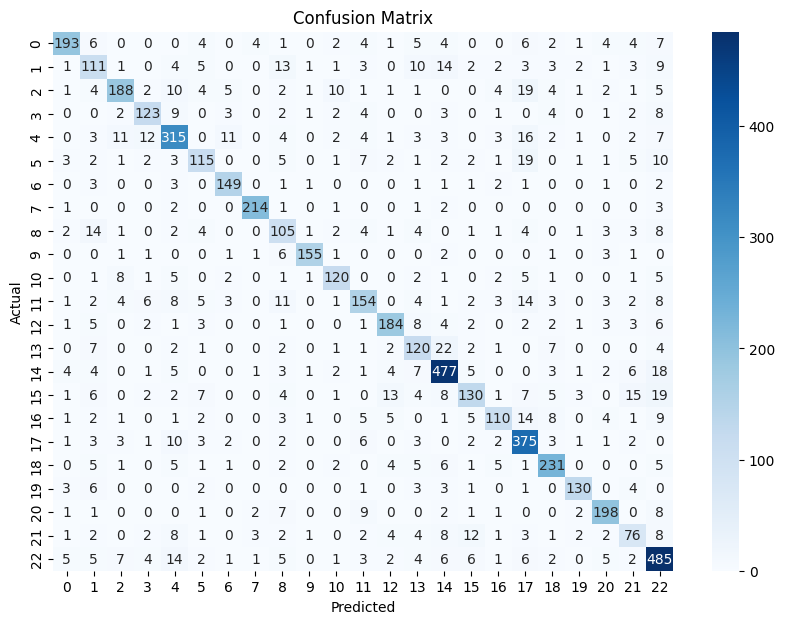

(0.7812828601472135, 0.782726120141294, 0.7812828601472135, 0.7798672940989553)

In [ ]:
class_names = get_class_names(train_artist_dataset)
evaluate_saved_model("artist_model.pth", val_artist_loader, class_names)